In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys
import pandas as pd
sys.path.append('../../param_search')
import param_search as ps

## Setup experiment

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [17]:
# define a job template and name format
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:rtx6000:2
#SBATCH --mem=128000M
#SBATCH -x v034
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project
nvidia-smi

python ../../../train.py \\
    --data_name emory \\
    --data_root /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/ \\
    --test_case {test_case} \\
    --test_phase {test_phase} \\
    --rho_value {rho_value} \\
    --conv_channels {conv_channels} \\
    --output_func {output_func} \\
    --interp_size {interp_size} \\
    --save_prefix {job_name} 

echo Done
'''
name_format = 'train__emory__{test_case}__{test_phase}__{rho_value}'

In [18]:
param_space = ps.ParamSpace(
    test_case=[None], #['Case1Pack', 'Case2Pack', 'Case3Pack', 'Case4Pack', 'Case5Pack', 'Case6Pack', 'Case7Pack', 'Case8Deploy', 'Case9Pack'],
    test_phase=[0],# 10, 20, 30, 40, 50, 60, 70, 80, 90],
    rho_value=[0, 1000, 'anat'],
    conv_channels=[32],
    interp_size=[5],
    output_func=['relu'],
)

for p in param_space:
    print(name_format.format(**p))

print(len(param_space))

train__emory__None__0__0
train__emory__None__0__1000
train__emory__None__0__anat
3


## Submit jobs

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [19]:
expt_name = [
    '2024-11-22__phantom__250',
    '2024-11-22__phantom__250__resub',
    '2024-11-30__emory__phase',
    '2024-12-02__emory__interp_size'
][-1]
expt_name

'2024-12-02__emory__interp_size'

In [22]:
do_submit = True
if do_submit:
    jobs = ps.submit(template, name_format, param_space, work_dir=expt_name)
    jobs.to_csv(f'{expt_name}.jobs')

100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/job_queues.py:235: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('', float('nan')).map(pd.to_numeric)


## Monitor jobs

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [23]:
jobs = pd.read_csv(f'{expt_name}.jobs', index_col=0)
status = ps.status(jobs, parse_stderr=True)
status

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/job_queues.py:235: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('', float('nan')).map(pd.to_numeric)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/__init__.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['PENDING' 'PENDING' 'PENDING']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  status.update(new_status)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/__init__.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in

,index,test_case,test_phase,rho_value,conv_channels,interp_size,output_func,job_name,partition,job_state,node_id,runtime,work_dir,array_idx,stdout,stderr
job_id,,,,,,,,,,,,,,,,
27268916,0,NaN,0,0,32,5,relu,train__emory__None__0__0,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27268917,1,NaN,0,1000,32,5,relu,train__emory__None__0__1000,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27268918,2,NaN,0,anat,32,5,relu,train__emory__None__0__anat,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN


In [8]:
status['job_state'] = status['job_state'].fillna('DONE')
status['stderr'] = status['stderr'].fillna('N/A')
status.groupby(['job_state', 'stderr'])[['job_name']].count()

,,job_name
job_state,stderr,
DONE,*** Where: This error was encountered inside /home/conda/feedstock_root/build_artifacts/fenics-pkgs_1724330428349/work/dolfin/la/PETScKrylovSolver.cpp.,3


In [9]:
error_jobs = status[status['stderr'] != ''].reset_index()[list(param_space.keys()) + ['job_name', 'work_dir']]
error_jobs

,test_case,test_phase,rho_value,conv_channels,output_func,job_name,work_dir
0,NaN,0,0,32,relu,train__emory__None__0__0,/ocean/projects/asc170022p/mtragoza/lung-proje...
1,NaN,0,1000,32,relu,train__emory__None__0__1000,/ocean/projects/asc170022p/mtragoza/lung-proje...
2,NaN,0,anat,32,relu,train__emory__None__0__anat,/ocean/projects/asc170022p/mtragoza/lung-proje...


## Analyze results

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [10]:
m = ps.metrics(jobs, sep=',')
m

,test_case,test_phase,rho_value,conv_channels,output_func,job_name,job_id,partition,job_state,node_id,...,e_850_corr,true_950_corr,true_900_corr,true_850_corr,e_dis0_corr,e_dis1_corr,e_dis2_corr,true_dis0_corr,true_dis1_corr,true_dis2_corr
0,NaN,0,0,32,relu,train__emory__None__0__0,27230771,BatComputer,PENDING,(None),...,0.011681,NaN,NaN,NaN,-0.009308,NaN,-0.009308,NaN,NaN,NaN
1,NaN,0,0,32,relu,train__emory__None__0__0,27230771,BatComputer,PENDING,(None),...,-0.007982,NaN,NaN,NaN,0.009552,0.001458,0.009502,NaN,NaN,NaN
2,NaN,0,0,32,relu,train__emory__None__0__0,27230771,BatComputer,PENDING,(None),...,0.031289,NaN,NaN,NaN,-0.051762,NaN,-0.051762,NaN,NaN,NaN
3,NaN,0,0,32,relu,train__emory__None__0__0,27230771,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0,1000,32,relu,train__emory__None__0__1000,27230772,BatComputer,PENDING,(None),...,-0.031652,NaN,NaN,NaN,-0.054977,NaN,-0.054977,NaN,NaN,NaN
5,NaN,0,1000,32,relu,train__emory__None__0__1000,27230772,BatComputer,PENDING,(None),...,-0.004712,NaN,NaN,NaN,-0.014990,NaN,-0.014990,NaN,NaN,NaN
6,NaN,0,1000,32,relu,train__emory__None__0__1000,27230772,BatComputer,PENDING,(None),...,0.031329,NaN,NaN,NaN,-0.065120,NaN,-0.065120,NaN,NaN,NaN
7,NaN,0,1000,32,relu,train__emory__None__0__1000,27230772,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0,1000,32,relu,train__emory__None__0__1000,27230772,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,0,anat,32,relu,train__emory__None__0__anat,27230773,BatComputer,PENDING,(None),...,0.041449,NaN,NaN,NaN,0.005953,NaN,0.005953,NaN,NaN,NaN


In [14]:
m.groupby(['job_name'])[['epoch']].max()

,epoch
job_name,
train__emory__None__0__0,1
train__emory__None__0__1000,1
train__emory__None__0__anat,1


In [16]:
unfinished_jobs = d[d.epoch < 100]
unfinished_jobs

,epoch
job_name,
train__emory__None__0__0,1
train__emory__None__0__1000,1
train__emory__None__0__anat,1


In [15]:
m.groupby(['job_name'])[['batch']].max()

,batch
job_name,
train__emory__None__0__0,2
train__emory__None__0__1000,3
train__emory__None__0__anat,5


In [78]:
m.columns

Index(['anat_range', 'dummy_targets', 'conv_channels', 'output_func',
       'job_name', 'job_id', 'partition', 'job_state', 'node_id', 'runtime',
       'work_dir', 'array_idx', 'epoch', 'batch', 'example', 'phase', 'rep',
       'u_error', 'u_pred_norm', 'u_true_norm', 'e_error', 'e_pred_norm',
       'e_true_norm', 'CTE', 'e_true_corr', 'e_anat_corr', 'true_anat_corr',
       'e_950_corr', 'e_900_corr', 'e_850_corr', 'true_950_corr',
       'true_900_corr', 'true_850_corr'],
      dtype='object')

In [ ]:
%autoreload
fig = ps.plot(
    m[(m.phase == 'train') & (m.epoch > 190) & (m.conv_channels > 8)],
    x=['dummy_targets', 'conv_channels', 'output_func'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)

<IPython.core.display.Javascript object>


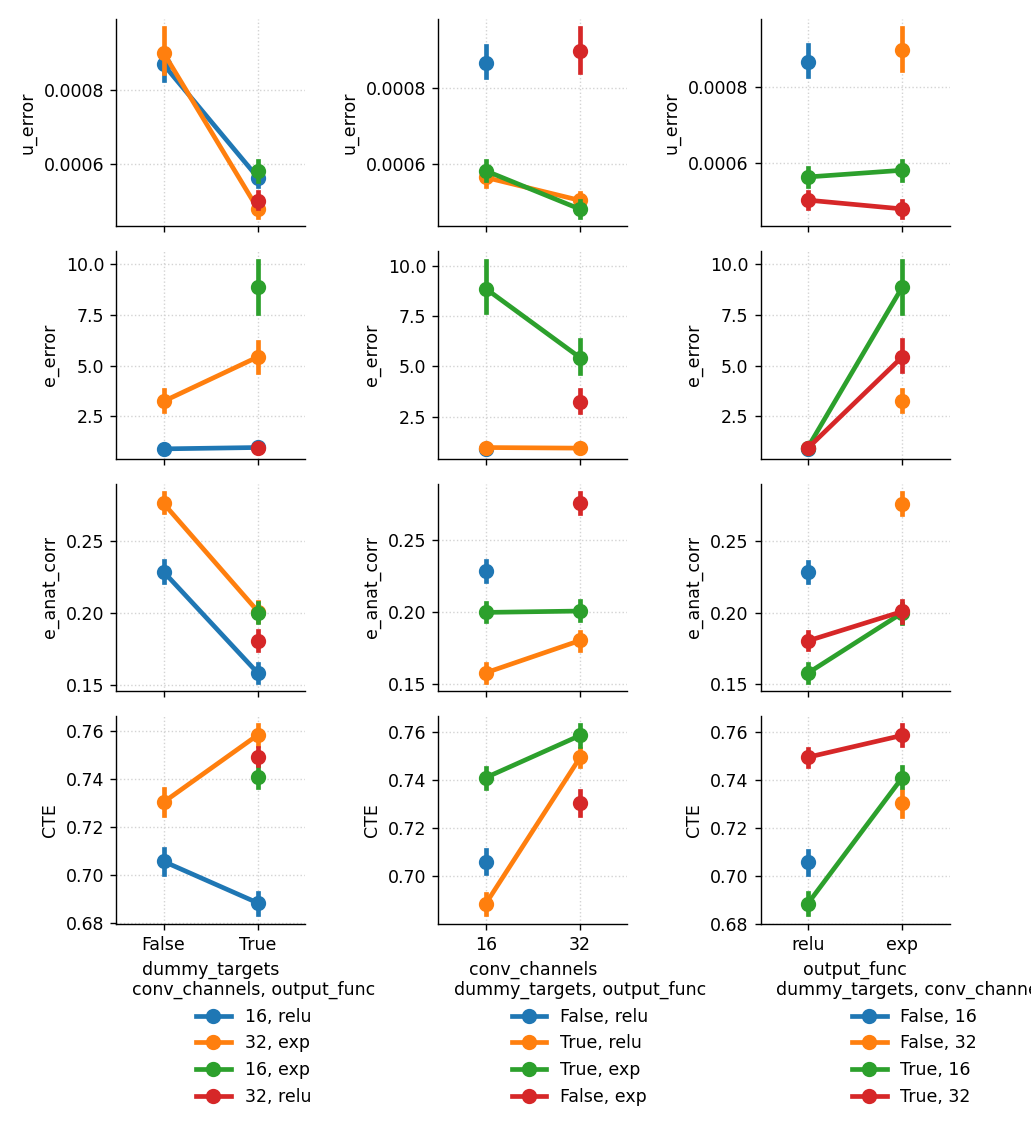

In [81]:
%autoreload
fig = ps.plot(
    m[(m.phase == 'train') & (m.epoch > 190) & (m.conv_channels > 8)],
    x=['dummy_targets', 'conv_channels', 'output_func'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)

<IPython.core.display.Javascript object>


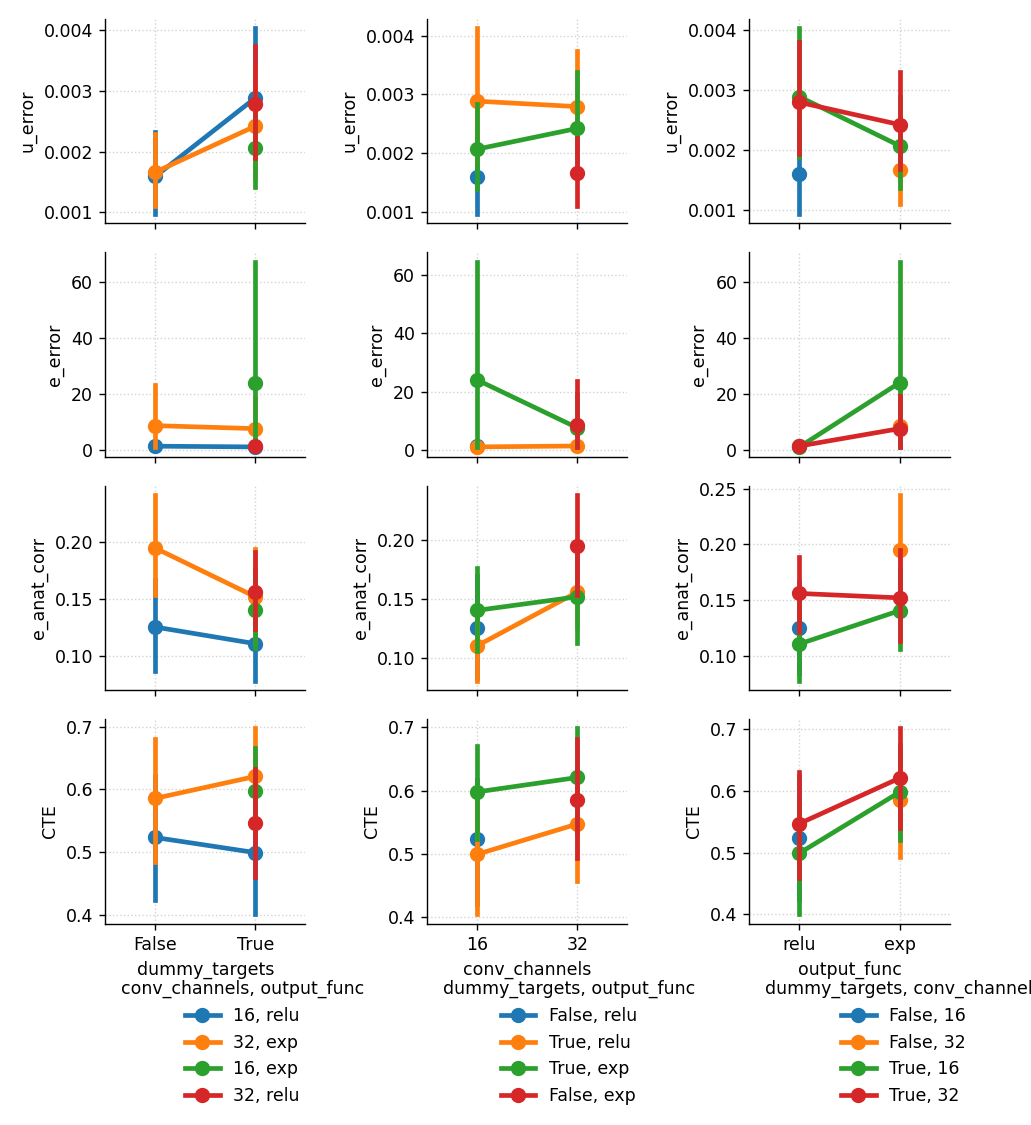

In [82]:
%autoreload
fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 190) & (m.conv_channels > 8)],
    x=['dummy_targets', 'conv_channels', 'output_func'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)

In [84]:
m[(m.phase == 'test') & (m.epoch > 190) & (m.conv_channels > 8)].groupby(['dummy_targets', 'conv_channels', 'output_func', 'phase'])[['u_error', 'e_error', 'e_anat_corr', 'CTE']].describe()

u_error                      \
                                                count      mean       std   
dummy_targets conv_channels output_func phase                               
False         16            relu        test     20.0  0.001592  0.001617   
              32            exp         test     20.0  0.001662  0.001393   
True          16            exp         test     20.0  0.002067  0.001691   
                            relu        test     20.0  0.002884  0.002647   
              32            exp         test     20.0  0.002420  0.001993   
                            relu        test     20.0  0.002790  0.002211   

                                                                             \
                                                    min       25%       50%   
dummy_targets conv_channels output_func phase                                 
False         16            relu        test   0.000198  0.000393  0.000782   
              32            exp         test   0.000164  0.000524  0.001012   
True          16            exp         test   0.000492  0.000960  0.001384   
                            relu        test   0.000470  0.001196  0.001697   
              32            exp         test   0.000418  0.001109  0.001761   
                            relu        test   0.000310  0.001285  0.002258   

                                                                  e_error  \
                                                    75%       max   count   
dummy_targets conv_channels output_func phase                               
False         16            relu        test   0.002180  0.005494    20.0   
              32            exp         test   0.002517  0.004392    20.0   
True          16            exp         test   0.002558  0.006746    20.0   
                            relu        test   0.004714  0.009315    20.0   
              32            exp         test   0.002808  0.006742    20.0   
                            relu        test   0.003387  0.007604    20.0   

                                                          ... e_anat_corr  \
                                                    mean  ...         75%   
dummy_targets conv_channels output_func phase             ...               
False         16            relu        test    1.333001  ...    0.182263   
              32            exp         test    8.668284  ...    0.274917   
True          16            exp         test   23.971448  ...    0.206008   
                            relu        test    1.075325  ...    0.164611   
              32            exp         test    7.602740  ...    0.238330   
                            relu        test    1.393699  ...    0.209315   

                                                          CTE            \
                                                    max count      mean   
dummy_targets conv_channels output_func phase                             
False         16            relu        test   0.326268  20.0  0.523165   
              32            exp         test   0.385551  20.0  0.585586   
True          16            exp         test   0.304233  20.0  0.597840   
                            relu        test   0.256176  20.0  0.499040   
              32            exp         test   0.359781  20.0  0.620617   
                            relu        test   0.284903  20.0  0.546983   

                                                                             \
                                                    std       min       25%   
dummy_targets conv_channels output_func phase                                 
False         16            relu        test   0.230240  0.182970  0.294335   
              32            exp         test   0.221956  0.206835  0.348600   
True          16            exp         test   0.174649  0.294312  0.427728   
                            relu        test   0.221738  0.146012  0.298760   
              32       